# Summary : linear regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for correlation matrix
import itertools # for computing combinations
from scipy.stats import halfnorm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler # for standardization

## Linear regression for prediction

### Mean Squared Error (MSE)

**Mean Squared Error (MSE)**. This can be calculated using the following formula:

<div style="font-size: 120%;">  
$$ MSE = \frac{1}{n} \sum_{i=1}^n (y_i − \hat{f}(x_i))^2, $$
</div>

where $y_i$ is the true values and $\hat{f}(x_i)$ is the predicted values by our model over $n$ samples.

In [2]:
true_values = [13.9, 20.3, 2.1, 8.8, 5.2]
predicted_vals = [14.3, 18.9, 3.4, 8.9, 5.0]

MSE = mean_squared_error(true_values, predicted_vals)
print('MSE :', MSE)
print('RMSE :', np.sqrt(MSE))
print('RMSE to compare to mean {0} and standard deviation {1} of dataset'.format(np.mean(true_values), np.std(true_values)))

MSE : 0.7720000000000011
RMSE : 0.8786353054595525
RMSE to compare to mean 10.060000000000002 and standard deviation 6.452472394361715 of dataset


### Correlation matrix

In [3]:
from sklearn.datasets import fetch_california_housing
houses = fetch_california_housing()
X = pd.DataFrame(houses.data, columns=houses.feature_names)
y = houses.target
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


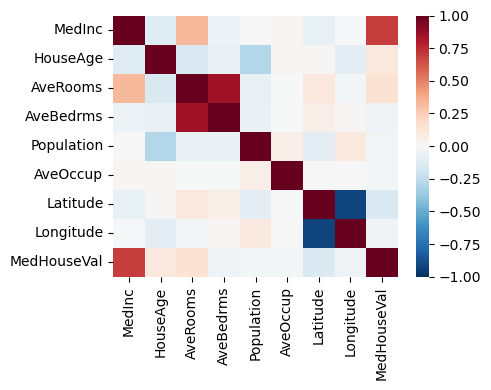

In [4]:
df_houses = pd.concat([X, pd.Series(y)], axis=1)
df_houses = df_houses.rename(columns={0:'MedHouseVal'})

fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(5,4))
sns.heatmap(df_houses.corr(), cmap="RdBu_r", vmin=-1, vmax=1, ax=ax);

* Features AveRooms and AveBedrms are highly correlated, as well as Latitude and Longitude, maybe some features should be removed from the models because they bring no more information.
* MedInc is highly correlated to the target feature : MedHouseVal, but it does not mean we need to remove it. On the contrary, it is important to keep it.

### Variance Inflation Factor (VIF)

In [5]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['features'] = X.columns
display(vif[vif['VIF']>5].sort_values(by=['VIF']))

high_vif = vif[vif['VIF']>5]['features']
high_vif.values

,VIF,features
1,7.195917,HouseAge
0,11.511140,MedInc
3,43.590314,AveBedrms
2,45.993601,AveRooms
6,559.874071,Latitude
7,633.711654,Longitude


array(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude',
       'Longitude'], dtype=object)

These features have high VIF (>5), meaning that there is possible collinearity, and thus some of those features should be removed from the model. However, it does not mean we need to remove all of them (we saw that it did not improve the model by removing all of them !).

### Train, test, split, and regression

The [diagram](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) below illustrates this process. Here the train and validation sets are used to do model assesment and model selection (NOTE: the test set is strictly forbidden from being used in any way during this process!). Once a model is selected the test set is used to do a final assesment of performance to see if the model selected will generalise as well as predicted.

<img src="./images/testtrainvalid.png" width="450px">

**Split dataset in train and test**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18)

**Evaluate the MSE by learning from the training dataset, and then testing the model on the test dataset**

In [7]:
def evaluate_mse(X_train, X_test, y_train, y_test, print_infos=False):   
    # fit model to training data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # predict y values for testing data set
    y_pred_test = model.predict(X_test)

    # evaluate MSE
    mse_test = mean_squared_error(y_test, y_pred_test)
    if print_infos:
        print('test MSE: {0}'.format(mse_test))
    
    # evaluate training MSE
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    if print_infos:
        print('training MSE: {0}'.format(mse_train))
    return mse_test, mse_train

In [8]:
mse_test0, mse_train0 = evaluate_mse(X_train, X_test, y_train, y_test, print_infos=True)

test MSE: 0.5461989819549831
training MSE: 0.5191938764206628


### Improving a model by removing features

In [9]:
X2 = X.drop(['AveRooms'], axis=1)
display(X2.head())
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state = 18)
mse_test2, mse_train2 = evaluate_mse(X2_train, X2_test, y2_train, y2_test, print_infos=True)

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,1.081081,565.0,2.181467,37.85,-122.25


test MSE: 0.5434110809200312
training MSE: 0.5299462745783092


Test MSE is smaller than the one from the initial model : this model is more accurate.

#### Selection of a model : computing the combinations and testing

In [10]:
# Calculation of the combinations
cl = []
for i in range(2,len(X.columns)):
    c = itertools.combinations(X.columns,i)
    for var in c:
        cl.append(list(var))

# Creation of a dataframe
df = pd.DataFrame()
df['Combinations'] = cl

# Addition of the MSE
l_mse_test = []
l_mse_train = []
l_better = []
for combination in cl:
    Xi_train, Xi_test, yi_train, yi_test = train_test_split(X[combination], y, random_state = 18)
    mse_test, mse_train = evaluate_mse(Xi_train, Xi_test, yi_train, yi_test)
    l_mse_test.append(mse_test)
    l_mse_train.append(mse_train)
    if(mse_test < mse_test0):
        l_better.append(True)
    else:
        l_better.append(False)
    
df['MSE_test'] = l_mse_test
df['MSE_train'] = l_mse_train
df['Better model'] = l_better

df['Length'] = df['Combinations'].apply(lambda x: len(x))
df.loc[df['Better model']==True,:]

,Combinations,MSE_test,MSE_train,Better model,Length
98,"[MedInc, HouseAge, Latitude, Longitude]",0.545367,0.539012,True,4
163,"[MedInc, HouseAge, AveRooms, Latitude, Longitude]",0.543630,0.537608,True,5
169,"[MedInc, HouseAge, AveBedrms, Latitude, Longit...",0.544814,0.531308,True,5
172,"[MedInc, HouseAge, Population, Latitude, Longi...",0.545418,0.538877,True,5
173,"[MedInc, HouseAge, AveOccup, Latitude, Longitude]",0.543926,0.537601,True,5
218,"[MedInc, HouseAge, AveRooms, Population, Latit...",0.543705,0.537533,True,6
219,"[MedInc, HouseAge, AveRooms, AveOccup, Latitud...",0.542221,0.536252,True,6
222,"[MedInc, HouseAge, AveBedrms, Population, Lati...",0.544834,0.531281,True,6
223,"[MedInc, HouseAge, AveBedrms, AveOccup, Latitu...",0.543401,0.529950,True,6
224,"[MedInc, HouseAge, Population, AveOccup, Latit...",0.543973,0.537533,True,6


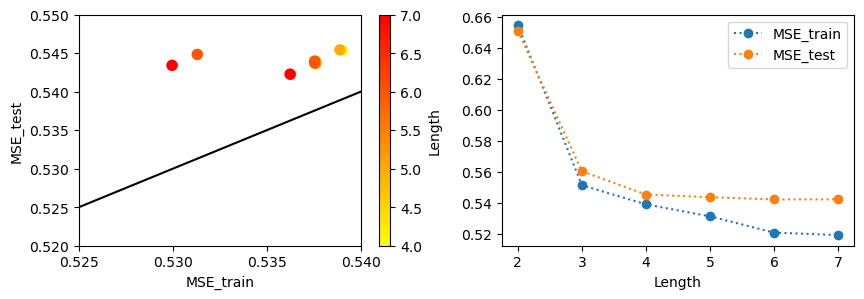

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
df.loc[df['Better model']==True,:].plot.scatter(x='MSE_train',y='MSE_test', xlim=(0.525,0.54), ylim=(0.52,0.55),
                                                    c='Length', colormap='autumn_r', s=50, ax=ax[0])
ax[0].plot(np.linspace(0.525,0.54,100),np.linspace(0.525,0.54,100), color='k')

df_length = df.groupby(['Length']).min(numeric_only=True)
df_length.plot(y=['MSE_train', 'MSE_test'], style=':o', ax=ax[1]);

* Best models are those where we have 7 variables (just need to remove AveRooms).
* MSE test are bigger than MSE train : normal behavior (otherwise it means the model is not stable, or we have a test dataset which fits by chance to the model).

## Cross-validation

### K-fold cross validation

A very common method called *k-fold* is often used, which actually splits the training set multiple times. This allows us to assess the accuracy of the model over $k$ validation splits of data. The [image below](http://ethen8181.github.io/machine-learning/model_selection/model_selection.html) illustrates how this works for $k = 5$ splits.

<img src="./images/kfold.png" width="450px">

In [12]:
lin_reg = LinearRegression()

cv_scores = cross_val_score(lin_reg, X_train, y_train, cv = 5, scoring='neg_mean_squared_error') 

print('mean MSE:',np.mean(-cv_scores))
print('std MSE:',np.std(-cv_scores))

mean MSE: 0.5207401218408914
std MSE: 0.01194732619299784


### Use of cross_val_predict to get the predicted values

In [13]:
y_train_predict = cross_val_predict(lin_reg, X_train, y_train, cv = 5) 

In [14]:
def display_predict(y,y_pred):
    fig, axs = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)

    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions");

The plots show quite nice agreement.


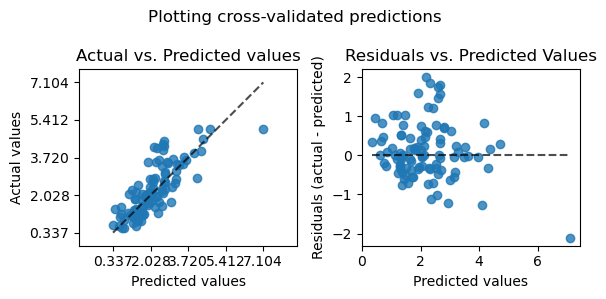

In [15]:
display_predict(y_train,y_train_predict)
print('The plots show quite nice agreement.')

In [16]:
print('MSE train compared to predicted :', mean_squared_error(y_train, y_train_predict))
print('Models are stable as MSE train and through cross-validation are close.')

MSE train compared to predicted : 0.5207401218408914
Models are stable as MSE train and through cross-validation are close.


### Evaluation on the test dataset

In [17]:
def get_predicted(X_train, X_test, y_train, y_test):
    # fit model to training data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # predict y values for testing data set
    y_pred_train = cross_val_predict(model, X_train, y_train, cv = 5) 
    y_pred_test = cross_val_predict(model, X_test, y_test, cv = 5) 
#     y_pred_test = model.predict(X_test)
#     y_pred_train = model.predict(X_train)
    return y_pred_test, y_pred_train

test MSE: 0.5461989819549831
training MSE: 0.5191938764206628


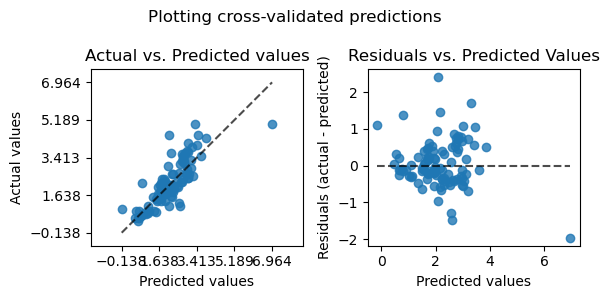

In [18]:
mse_test, mse_train = evaluate_mse(X_train, X_test, y_train, y_test, print_infos=True)
y_test_predict, y_train_predict = get_predicted(X_train, X_test, y_train, y_test)
display_predict(y_test,y_test_predict)

## Regularisation

**Lasso vs Ridge** 

These are both types of regularised linear regression.

***Lasso***: objectif is to minimize : 
$ RSS + \lambda \sum |\beta | $
* can force coefficients exactly to zero: behaves thus as variable selection


***Ridge***: objectif is to minimize: 
$ RSS + \lambda \sum \beta_i^2 $
* does not force coefficients exactly to zero
* interestig when there are more predictors than observations

### Import, remove categorical variables, cleaning

In [19]:
datapath='./data/'
hitters = pd.read_csv(datapath+'Hitters.csv')
hitters.rename({'Unnamed: 0':'Name'},inplace=True, axis=1)

# remove categorical variables
hitters = hitters.drop(['Name','League','Division','NewLeague'], axis=1)

# clean data
hitters_clean = hitters.dropna(axis=0, how='any')
hitters_clean.head()

# isolate y
salary = hitters_clean.pop('Salary')
hitters_clean.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25


### Split the dataset in train and test datasets, Standardization of the X features

In [20]:
# to keep the dataframe
def standardization(X):
    sc = StandardScaler()
    columns = X.columns
    return pd.DataFrame(sc.fit_transform(X), columns=columns)

In [21]:
# make train test split
X_train, X_test, y_train, y_test = train_test_split(hitters_clean, salary, random_state = 91)

## standardization X
X_train = standardization(X_train)
X_test = standardization(X_test)

*Note : Standardize AFTER splitting the dataset, to have the right mean and standard deviation for each dataset*

## Lasso 

### MSE

In [22]:
lasso = Lasso(alpha = 100)
cv_scores = cross_val_score(lasso, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
print('mean MSE:',np.mean(-cv_scores))
print('std MSE:',np.std(-cv_scores))

mean MSE: 127987.79248129882
std MSE: 23687.28891415606


### Grid search

In [23]:
lasso = Lasso(max_iter=10000)

param_grid = [
 {'alpha': [0.001, 0.01, 0.1, 1, 3, 10, 100, 1000]}
 ]

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

display(grid_results.head())

grid_search.best_estimator_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008713,0.001033,0.000892,0.000103,0.001,{'alpha': 0.001},-117288.489111,-100033.982813,-154895.285151,-77457.287004,-102042.352309,-140029.376504,-66136.828878,-102458.100455,-165534.233317,-60958.336423,-108683.427196,34124.487112,2
1,0.006182,0.000887,0.000755,0.000016,0.01,{'alpha': 0.01},-117320.011489,-100113.385312,-154720.763905,-77464.055412,-102136.641863,-139995.219107,-66130.039737,-102470.255234,-165570.124645,-60889.388770,-108680.988547,34110.366678,1
2,0.004080,0.000885,0.000759,0.000020,0.1,{'alpha': 0.1},-117745.858759,-100926.259835,-153001.106625,-77563.619931,-103105.920966,-139631.120056,-66067.714694,-102632.552329,-165992.152856,-60221.196710,-108688.750276,33984.199667,3
3,0.002495,0.000248,0.000894,0.000403,1,{'alpha': 1},-122789.463357,-103720.972907,-140011.067137,-75861.880040,-112608.467237,-138051.867720,-66382.991208,-102736.052601,-170168.071090,-56482.296663,-108881.312996,33896.634721,4
4,0.001636,0.000197,0.000752,0.000033,3,{'alpha': 3},-121553.903202,-121548.600217,-127638.881449,-73627.263056,-124953.992721,-133156.367055,-68218.440798,-99201.088981,-171696.532431,-53784.036005,-109537.910592,33893.487332,5


Lasso(alpha=0.01, max_iter=10000)

### Randomized search

In [24]:
lasso = Lasso(max_iter=10000)

param_dist = [
    {'alpha' : halfnorm(loc=0,scale=100)}
]

grid_search = RandomizedSearchCV(lasso, param_dist, n_iter=100, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

display(grid_results.head())

grid_search.best_estimator_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001932,0.000705,0.001027,0.000276,30.937517,{'alpha': 30.937516662074728},-111099.026314,-138889.214605,-142259.682587,-66887.959439,-157506.193441,-102447.553160,-71554.113835,-88463.454549,-200037.398893,-50414.989738,-112955.958656,44227.419430,17
1,0.001523,0.000112,0.000863,0.000050,93.862594,{'alpha': 93.8625936271754},-100628.293431,-156913.758252,-161629.242386,-60994.640068,-197443.123564,-95843.398342,-101123.288438,-83234.220471,-256519.883608,-60978.621927,-127530.847049,60659.386395,56
2,0.001410,0.000206,0.000786,0.000019,39.139823,{'alpha': 39.139822745480295},-108187.328201,-139081.136040,-142986.762231,-65508.573575,-161873.397256,-101053.622635,-74124.587948,-87141.448372,-210467.168859,-50400.767159,-114082.479228,46878.685509,26
3,0.001330,0.000062,0.000818,0.000028,154.063742,{'alpha': 154.06374183093027},-112012.442483,-207382.078842,-198799.076709,-65021.024126,-229053.402161,-96857.259503,-140630.013956,-86816.270493,-298696.185537,-80350.104539,-151561.785835,73776.267920,76
4,0.001377,0.000078,0.000815,0.000023,56.247071,{'alpha': 56.24707081093224},-103366.061450,-141615.308845,-146915.895469,-63221.260658,-172511.295593,-98660.489694,-80724.152221,-85001.916741,-233830.972466,-51713.234396,-117756.058753,53143.851008,37


Lasso(alpha=2.2942922229454226, max_iter=10000)

In [25]:
alpha_l = grid_search.best_params_
print('Best alpha :', alpha_l['alpha'])

Best alpha : 2.2942922229454226


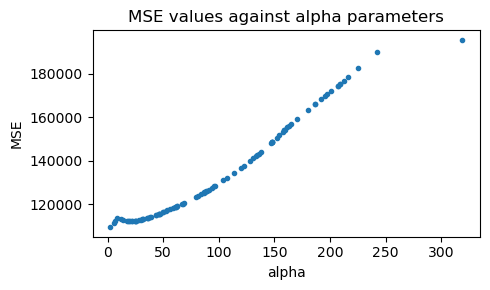

In [26]:
# plot cv values against alpha parameters
fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(5,3))
ax.plot(grid_results['param_alpha'],-grid_results['mean_test_score'], '.')
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')
ax.set_title('MSE values against alpha parameters');

## Ridge

### MSE

In [27]:
ridge = Ridge(max_iter=10000)
cv_scores = cross_val_score(ridge, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
print('mean MSE:',np.mean(-cv_scores))
print('std MSE:',np.std(-cv_scores))

mean MSE: 105587.69099432668
std MSE: 13233.43270746684


### Grid Search

In [28]:
ridge = Ridge(max_iter=10000)

param_grid = [
 {'alpha': np.linspace(0.001,10,100)}
 ]

grid_search = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_results = pd.DataFrame(grid_search.cv_results_)

display(grid_results.head())

# Print the best hyperparameter for model performance....
grid_search.best_estimator_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002038,0.000669,0.001119,0.000220,0.001,{'alpha': 0.001},-117315.328194,-100034.002639,-154748.077336,-77462.100223,-102052.601133,-140034.423215,-66132.141297,-102467.017213,-165549.222458,-60931.083376,-108672.599708,34111.812968,57
1,0.001264,0.000117,0.000830,0.000043,0.102,{'alpha': 0.10200000000000001},-119239.856526,-100818.868736,-144256.501422,-77579.626116,-103874.837980,-139909.828590,-65925.979442,-103003.356015,-166738.891605,-58995.114758,-108034.286119,33316.668879,35
2,0.001248,0.000041,0.000849,0.000034,0.203,{'alpha': 0.203},-120061.445446,-101504.318751,-139346.692824,-77326.597357,-105322.063080,-139497.200522,-66008.275722,-103072.640246,-167253.410452,-58304.561929,-107769.720633,32981.884149,26
3,0.001294,0.000182,0.000896,0.000132,0.304,{'alpha': 0.30400000000000005},-120464.144320,-102162.862246,-136442.094185,-76979.753637,-106549.087095,-138958.320740,-66175.405760,-102976.670895,-167520.405860,-57972.324037,-107620.106878,32771.470298,20
4,0.001412,0.000251,0.000967,0.000189,0.405,{'alpha': 0.405},-120673.412893,-102812.704525,-134511.530800,-76615.988448,-107631.151672,-138361.429920,-66370.314470,-102812.364393,-167675.857373,-57781.536240,-107524.629073,32616.066458,15


Ridge(alpha=1.011, max_iter=10000)

In [29]:
alpha_r = grid_search.best_params_
print('Best alpha :', alpha_r['alpha'])

Best alpha : 1.011


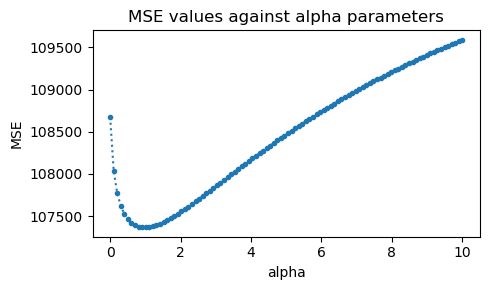

In [30]:
# plot cv values against alpha parameters
fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(5,3))
ax.plot(grid_results['param_alpha'],-grid_results['mean_test_score'], ':.')
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')
ax.set_title('MSE values against alpha parameters');

We see that the minimum MSE is reached for alpha around 1. 

## Extract the coefficients beta

### Lasso

In [31]:
alphas = np.logspace(-5, 5, 100)
coefs_l = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X_train, y_train)
    coefs_l.append(lasso.coef_)

/home/aline.cisse@Digital-Grenoble.local/anaconda3/envs/Stats/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.309e+07, tolerance: 8.842e+03
  model = cd_fast.enet_coordinate_descent(
/home/aline.cisse@Digital-Grenoble.local/anaconda3/envs/Stats/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.306e+07, tolerance: 8.842e+03
  model = cd_fast.enet_coordinate_descent(
/home/aline.cisse@Digital-Grenoble.local/anaconda3/envs/Stats/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might wa

### Ridge

In [32]:
alphas = np.logspace(-5, 5, 100)
coefs_r = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs_r.append(ridge.coef_)

### Plot coefficients beta as a function of alpha

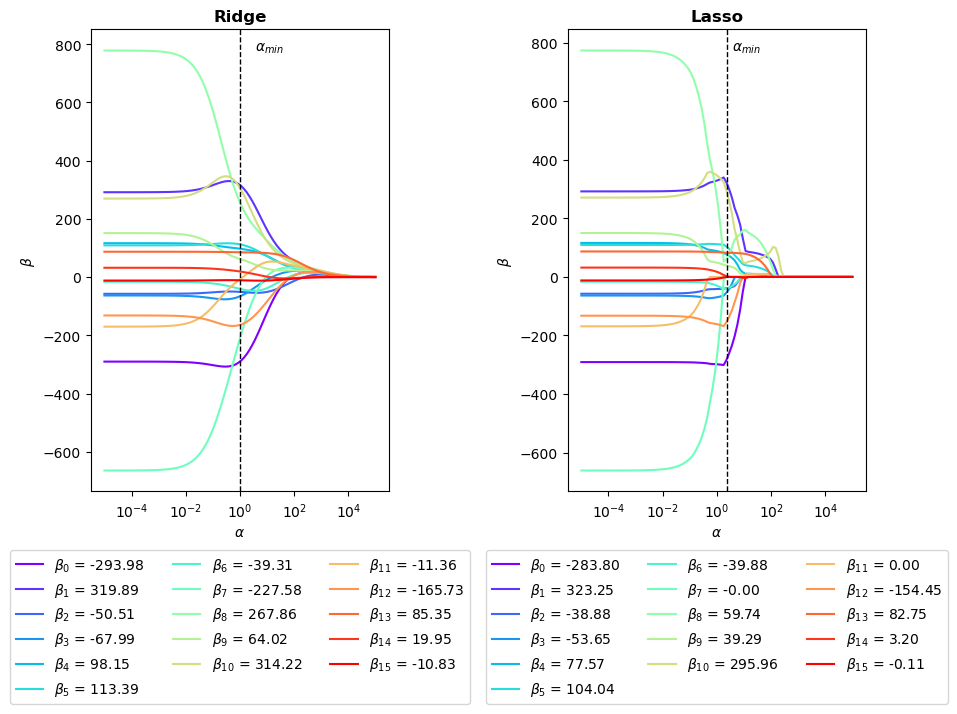

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
plt.subplots_adjust(wspace=0.6)
colors = plt.cm.rainbow(np.linspace(0,1,len(coefs_r[0])))

for i in range(len(coefs_r[0])):
    i_alpha = np.where(np.logical_and(alphas > alpha_r['alpha']-0.25, alphas < alpha_r['alpha']+0.25))[0][0]
    b = np.transpose(coefs_r)[i][i_alpha]
    ax[0].plot(alphas, np.transpose(coefs_r)[i], color=colors[i], label=r'$\beta_{%d}$ = %1.2f'%(i,b))
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[0].legend(loc='lower center', bbox_to_anchor=[0.5,-0.475],ncols=3)
ax[0].axvline(x=alpha_r['alpha'], linewidth=1, linestyle='--', color='k')
ax[0].text(x=0.55, y=0.975, ha='left', va='top', s=r'$\alpha_{min}$', transform=ax[0].transAxes)
ax[0].set_title('Ridge', fontweight='bold')

for i in range(len(coefs_l[0])):
    i_alpha = np.where(np.logical_and(alphas > alpha_l['alpha']-0.25, alphas < alpha_l['alpha']+0.25))[0][0]
    b = np.transpose(coefs_l)[i][i_alpha]
    ax[1].plot(alphas, np.transpose(coefs_l)[i], color=colors[i], label=r'$\beta_{%d}$ = %1.2f'%(i,b))
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\beta$')
ax[1].legend(loc='lower center', bbox_to_anchor=[0.5,-0.475],ncols=3)
ax[1].axvline(x=alpha_l['alpha'], linewidth=1, linestyle='--', color='k')
ax[1].text(x=0.55, y=0.975, ha='left', va='top', s=r'$\alpha_{min}$', transform=ax[1].transAxes)
ax[1].set_title('Lasso', fontweight='bold');